We will follow [de Boyer Montegut et al. (2004)](http://journals.ametsoc.org/doi/abs/10.1175/2009JTECHO543.1) and use the density criteria, i.e. the MLD will be defined where the density difference from the surface value exceeds 0.03 kg m$^{-3}$

In [10]:
import numpy as np
import xarray as xray
import gsw
import os
from scipy import io
from scipy.optimize import curve_fit
from itertools import product

from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
basedir = '/data/scratch/takaya/POP_data/'

In [12]:
fname = os.path.join(basedir, '3D_Monthly/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-0081.Jan.timeavg.nc')
ex = xray.open_dataset(fname, decode_times=False)

maskU = ex.KMU > 1
maskT = ex.KMT > 1
latT = ex.TLAT.where(maskT)
lonT = ex.TLONG.where(maskT)
latU = ex.ULAT.where(maskU)
lonU = ex.ULONG.where(maskU)

areaT = 1e-4 * ex.TAREA.where(maskT).values
zU = 1e-2 * ex.UVEL.z_t.values
zTop = 1e-2 * ex.z_w.values
dz = np.diff(zU)

In [4]:
npz = np.load(os.path.join(basedir, 'POP_Nsquared_winter.npz'))
N2_win = npz['N2']

npz = np.load(os.path.join(basedir, 'POP_Nsquared_summer.npz'))
N2_sum = npz['N2']

In [5]:
N2npz = np.load(os.path.join(basedir, 'Nsquared_seasons_1deg.npz'))
N2_win_1deg = N2npz['N2_win']
N2_sum_1deg = N2npz['N2_sum']

In [6]:
rhowinnpz = np.load(os.path.join(basedir, 'Density_winter.npz'))
rho_win = rhowinnpz['rho']

rhosumnpz = np.load(os.path.join(basedir, 'Density_summer.npz'))
rho_sum = rhosumnpz['rho']

In [4]:
ugwinnpz = np.load(os.path.join(basedir, 'zonal_geostrophicVel_winter.npz'))
vgwinnpz = np.load(os.path.join(basedir, 'meridional_geostrophicVel_winter.npz'))
ugsumnpz = np.load(os.path.join(basedir, 'zonal_geostrophicVel_summer.npz'))
vgsumnpz = np.load(os.path.join(basedir, 'meridional_geostrophicVel_summer.npz'))

Ug_win = ugwinnpz['ug_1deg']
Vg_win = vgwinnpz['vg_1deg']
Ug_sum = ugsumnpz['ug_1deg']
Vg_sum = vgsumnpz['vg_1deg']
lat = ugwinnpz['lat1']
lon = ugwinnpz['lon1']

# Aggregate

In [8]:
def aggregate(data, factor=2, mean=True):
    ndim = data.ndim
    shape = data.shape
    # promote single value to list
    if isinstance(factor, int):
        factors = ndim * [factor,]
#         print 'ndim: ', ndim, ' factors: ', factors
    # check we have the right number of dimensions
    assert len(factors) == ndim
    # make sure shapes are compatible
    for s, fac in zip(shape, factors):
#         print 's: ', s, ' fac: ', fac
        assert s % factor == 0
    out = 0
    # it is lazy to use a set...don't have to figure out the necessary logic
    slices = []
    for start_indices in product(*[range(f) for f in factors]):
        slices.append(
            [slice(sidx, s, factor) for sidx, s in zip(start_indices, shape)]
        )
    
    # how would we generalize to other reduce functions?
    result = reduce(np.add, [data[sl] for sl in slices])
    if mean:
        result /= len(slices)
    return result

In [9]:
Nagg = 10

Nz, Ny, Nx = rho_win.shape
rho_sum_agg = np.empty((Nz, Ny/Nagg, Nx/Nagg))
rho_sum_agg[:] = np.nan
rho_win_agg = rho_sum_agg.copy()

for k in range(Nz):
    rho_win_agg[k] = aggregate(rho_win[k], factor=Nagg)
    rho_sum_agg[k] = aggregate(rho_sum[k], factor=Nagg)

In [10]:
Nz, Ny, Nx = N2_win.shape
N2_sum_agg = np.empty((Nz, Ny/Nagg, Nx/Nagg))
N2_sum_agg[:] = np.nan
N2_win_agg = N2_sum_agg.copy()

for k in range(Nz):
    N2_win_agg[k] = aggregate(N2_win[k], factor=Nagg)
    N2_sum_agg[k] = aggregate(N2_sum[k], factor=Nagg)

In [36]:
print rho_win_agg.shape

(62, 240, 360)


In [11]:
gsw.rho?

In [159]:
print rho_win_agg.shape

(62, 240, 360)


# Find the vertical indices corresponding to the MLD

In [11]:
Nz, Ny, Nx = rho_win_agg.shape
kz_win = np.zeros((Ny, Nx))
kz_win[:] = np.nan
kz_sum = kz_win.copy()

for j in range(Ny):
    for i in range(Nx):
        if ~np.isnan(rho_win_agg[:,j,i]).all():
            kz_win[j,i] = np.nanargmin(np.absolute(rho_win_agg[:,j,i] - rho_win_agg[0,j,i] - .03))
        if ~np.isnan(rho_sum_agg[:,j,i]).all():
            kz_sum[j,i] = np.nanargmin(np.absolute(rho_sum_agg[:,j,i] - rho_sum_agg[0,j,i] - .03))

In [38]:
MLD_win = np.zeros((Ny, Nx))
MLD_win[:] = np.nan
MLD_sum = MLD_win.copy()

for j in range(Ny):
    for i in range(Nx):
        if ~np.isnan(kz_win[j,i]):
            MLD_win[j,i] = zU[int(kz_win[j,i])]
        if ~np.isnan(kz_sum[j,i]):
            MLD_sum[j,i] = zU[int(kz_sum[j,i])]

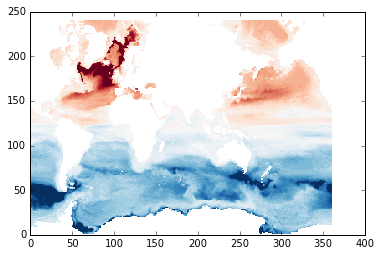

In [39]:
plt.pcolormesh(np.ma.masked_invalid(MLD_win - MLD_sum), cmap='RdBu_r',
              vmin=-2e2, vmax=2e2)

# Add metadata

In [40]:
dUdz_win = (-np.roll(Ug_win, -1, axis=0) + Ug_win)[:-1] / dz[:, np.newaxis, np.newaxis]
dUdz_sum = (-np.roll(Ug_sum, -1, axis=0) + Ug_sum)[:-1] / dz[:, np.newaxis, np.newaxis]

dVdz_win = (-np.roll(Vg_win, -1, axis=0) + Vg_win)[:-1] / dz[:, np.newaxis, np.newaxis]
dVdz_sum = (-np.roll(Vg_sum, -1, axis=0) + Vg_sum)[:-1] / dz[:, np.newaxis, np.newaxis]

In [12]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [13]:
lat1D = lat[:, 290].copy()
nans, x= nan_helper(lat1D)
lat1D[nans]= np.interp(x(nans), x(~nans), lat1D[~nans])

metalat = np.zeros_like(lat1D)
for i in range(len(lat1D)):
    metalat[i] = round(lat1D[i], 3)

In [43]:
print metalat

[-77.437 -77.437 -77.437 -77.015 -76.592 -76.17  -75.747 -75.324 -74.902
 -74.479 -74.057 -73.634 -73.211 -72.789 -72.366 -71.943 -71.521 -71.098
 -70.676 -70.253 -69.83  -69.408 -68.985 -68.562 -68.14  -67.717 -67.295
 -66.872 -66.449 -66.027 -65.604 -65.182 -64.757 -64.327 -63.89  -63.446
 -62.995 -62.537 -62.072 -61.6   -61.12  -60.633 -60.139 -59.637 -59.127
 -58.61  -58.084 -57.551 -57.011 -56.462 -55.905 -55.34  -54.767 -54.185
 -53.595 -52.997 -52.391 -51.776 -51.152 -50.521 -49.88  -49.231 -48.573
 -47.907 -47.232 -46.548 -45.855 -45.154 -44.444 -43.725 -42.998 -42.262
 -41.517 -40.763 -40.001 -39.23  -38.451 -37.663 -36.867 -36.062 -35.249
 -34.428 -33.599 -32.762 -31.916 -31.063 -30.202 -29.334 -28.458 -27.575
 -26.685 -25.787 -24.883 -23.973 -23.055 -22.132 -21.202 -20.267 -19.325
 -18.379 -17.427 -16.468 -15.509 -14.543 -13.572 -12.598 -11.62  -10.639
  -9.655  -8.667  -7.677  -6.685  -5.691  -4.695  -3.697  -2.699  -1.7
  -0.7     0.3     1.3     2.299   3.298   4.296   5.

In [14]:
lon1D = lon[44].copy()
nans, x= nan_helper(lon1D)
lon1D[nans]= np.interp(x(nans), x(~nans), lon1D[~nans])

metalon = np.zeros_like(lon1D)
for i in range(len(lon1D)):
    metalon[i] = round(lon1D[i], 3)

In [45]:
print metalon

[ 250.5  251.5  252.5  253.5  254.5  255.5  256.5  257.5  258.5  259.5
  260.5  261.5  262.5  263.5  264.5  265.5  266.5  267.5  268.5  269.5
  270.5  271.5  272.5  273.5  274.5  275.5  276.5  277.5  278.5  279.5
  280.5  281.5  282.5  283.5  284.5  285.5  286.5  287.5  288.5  289.5
  290.5  291.5  292.5  293.5  294.5  295.5  296.5  297.5  298.5  299.5
  300.5  301.5  302.5  303.5  304.5  305.5  306.5  307.5  308.5  309.5
  310.5  311.5  312.5  313.5  314.5  315.5  316.5  317.5  318.5  319.5
  320.5  321.5  322.5  323.5  324.5  325.5  326.5  327.5  328.5  329.5
  330.5  331.5  332.5  333.5  334.5  335.5  336.5  337.5  338.5  339.5
  340.5  341.5  342.5  343.5  344.5  345.5  346.5  347.5  348.5  349.5
  350.5  351.5  352.5  353.5  354.5  355.5  356.5  357.5  358.5  359.5
    0.5    1.5    2.5    3.5    4.5    5.5    6.5    7.5    8.5    9.5
   10.5   11.5   12.5   13.5   14.5   15.5   16.5   17.5   18.5   19.5
   20.5   21.5   22.5   23.5   24.5   25.5   26.5   27.5   28.5   29.5
   30.

In [ ]:
MLD_winmeta = xray.DataArray(MLD_win, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Latitude_t', 'Longitude_t'])
MLD_summeta = xray.DataArray(MLD_sum, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                             dims=['Latitude_t', 'Longitude_t'])

In [ ]:
kz_winmeta = xray.DataArray(kz_win, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Latitude_t', 'Longitude_t'])
kz_summeta = xray.DataArray(kz_sum, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                             dims=['Latitude_t', 'Longitude_t'])

N2_winmeta = xray.DataArray(N2_win_agg, coords=[('Depth_mid', zTop[1:]), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])
N2_summeta = xray.DataArray(N2_sum_agg, coords=[('Depth_mid', zTop[1:]), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])

N2_1degwinmeta = xray.DataArray(N2_win_1deg, coords=[('Depth_mid', zTop[1:]), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])
N2_1degsummeta = xray.DataArray(N2_sum_1deg, coords=[('Depth_mid', zTop[1:]), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])

dudz_winmeta = xray.DataArray(dUdz_win, coords=[('Depth_mid', zTop[1:]), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])
dudz_summeta = xray.DataArray(dUdz_sum, coords=[('Depth_mid', zTop[1:]), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])

In [17]:
rho_winmeta = xray.DataArray(rho_win_agg, coords=[('Depth_mid', zU), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])
rho_summeta = xray.DataArray(rho_sum_agg, coords=[('Depth_mid', zU), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])

In [119]:
def plt_func(N2, MLD, rho, dudz, kz, lat, lon, region):
    
    kz = kz.sel(Latitude_t=lat, Longitude_t=lon).values
    dudz = dudz.sel(Latitude_t=lat, Longitude_t=lon).values[:int(2*kz)]
    N2 = N2.sel(Latitude_t=lat, Longitude_t=lon).values[:int(2*kz)]
    rho = rho.sel(Latitude_t=lat, Longitude_t=lon).values[:int(2*kz)]
    MLD = MLD.sel(Latitude_t=lat, Longitude_t=lon).values
    print 'MLD is:', MLD
    print N2
    print dudz
    
    fig, ax1 = plt.subplots()
    ax1.plot()
    ax1.plot(1e4*N2, -zTop[1:int(2*kz)+1], 'b.-')
    ax1.plot(np.linspace(0., 0.2, 10), 
             -MLD*np.ones(10), 'k')
    ax1.set_xlabel(r'$N^2 \ \times 10^{-4}$', color='b', fontsize=14)
#     if N2.min() > 0.:
#         ax1.set_xlim([1e4*N2.min()*.5, 1e4*N2.max()*2.])
#     else:
#         ax1.set_xlim([1e4*N2.min()*2., 1e4*N2.max()*2.])
    for tl in ax1.get_xticklabels():
        tl.set_color('b')

    ax2 = ax1.twiny()
    ax2.plot(1e2*dudz, -zTop[1:int(2*kz)+1], 'r.-')
    ax2.set_xlabel(r'$\frac{du}{dz} \ \times 10^{-2}$', fontsize=16, y=1.1, color='red')
#     if dudz.min() > 0.:
#         ax2.set_xlim([9e1*dudz.min(), 1.1e2*dudz.max()])
#     else:
#         ax2.set_xlim([1.1e2*dudz.min(), 1.1e2*dudz.max()])
    for tl in ax2.get_xticklabels():
        tl.set_color('r')
        
    ax3 = ax1.twiny()
    ax3.plot(rho - 1e3, -zU[:int(2*kz)], 'g.-')
    ax3.set_xlabel(r'$\rho \ + 10^{3}$', fontsize=16, y=1.1, color='green')
#     ax3.set_xlim([.98*(rho-1e3).min(), 1.02*(rho-1e3).max()])
    for tl in ax3.get_xticklabels():
        tl.set_color('g')
    
    title = region
    plt.title(title, y=1.14)
    plt.show()

In [18]:
lats = np.array([39.232, 45.133, 17.045, 41.817, 55.616, 23.606, -51.776])
lons = np.array([155.5, 172.5, 240.5, 300.5, 340.5, 300.5,150.5])
regions = np.array(['Kuroshio', 'north of Kuroshio', 'East Pacific', 'Gulf Stream', 'northeast Atlantic', 'Sargasso Sea', 'ACC'])

In [21]:
rhoKuro_win = rho_winmeta.sel(Latitude_t=lats[0], Longitude_t=lons[0]).values
rhoKuro_sum = rho_summeta.sel(Latitude_t=lats[0], Longitude_t=lons[0]).values

rhoGS_win = rho_winmeta.sel(Latitude_t=lats[3], Longitude_t=lons[3]).values
rhoGS_sum = rho_summeta.sel(Latitude_t=lats[3], Longitude_t=lons[3]).values

## WINTER

MLD is: 115.0
[  3.29126653e-07   8.23793066e-07   1.16675528e-06   1.72430808e-06
   2.04425814e-06   2.36436960e-06   2.77914966e-06   3.38785636e-06
   4.09910804e-06   5.68841638e-06   8.51044930e-06   1.44006770e-05
   2.04877440e-05   2.48518183e-05   2.99761539e-05   3.53206809e-05
   3.96629930e-05   4.24950344e-05   4.51305853e-05   4.52965017e-05
   4.50164417e-05   4.47495901e-05]
[ 0.0002      0.00020001  0.00019998  0.00019998  0.00019993  0.00019955
  0.00019882  0.00019845  0.00019855  0.0001984   0.00019681  0.00019184
  0.00018438  0.0001751   0.00016644  0.00015742  0.0001482   0.00013881
  0.00013134  0.00012549  0.00011822  0.00011198]


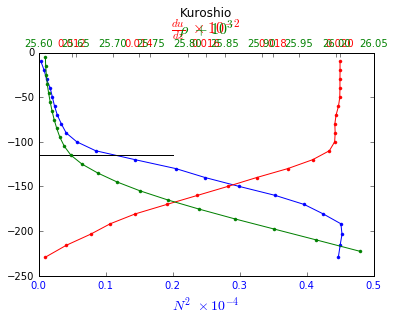

MLD is: 105.0
[  6.03644885e-07   9.47285854e-07   1.11651328e-06   1.24728212e-06
   1.31532016e-06   1.49706479e-06   1.80981578e-06   2.59409545e-06
   5.00505929e-06   1.51496956e-05   4.04122695e-05   7.07367410e-05
   8.08139444e-05   7.97468469e-05   7.10065798e-05   5.56892687e-05
   4.66905846e-05   4.20432210e-05   3.78808124e-05   3.55391059e-05]
[  1.03697594e-05   1.03539008e-05   1.02629705e-05   1.00481122e-05
   9.79182390e-06   9.82787634e-06   1.00392439e-05   1.04405504e-05
   1.18700557e-05   1.60880950e-05   2.49774071e-05   4.92253228e-05
   7.16242018e-05   9.05996242e-05   9.98250181e-05   1.09079484e-04
   1.18043470e-04   1.24348926e-04   1.27800426e-04   1.29378399e-04]


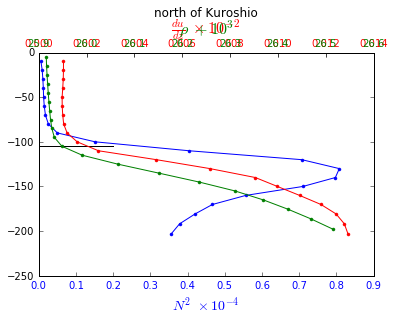

MLD is: 25.0
[  4.95362833e-06   1.42021880e-05   4.22697672e-05   6.48951412e-05]
[ 0.00060712  0.00061454  0.00065071  0.00071588]


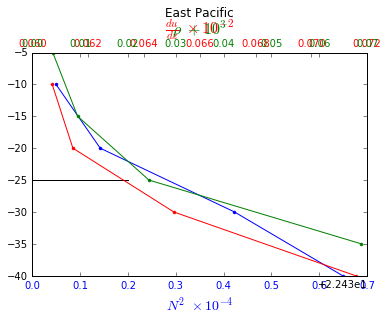

MLD is: 35.0
[  3.71686666e-06   1.04232873e-05   1.58213892e-05   1.58884252e-05
   1.46540372e-05   1.50166795e-05]
[  7.45492737e-05   8.02237210e-05   8.94088154e-05   9.72332092e-05
   1.03046283e-04   1.08452604e-04]


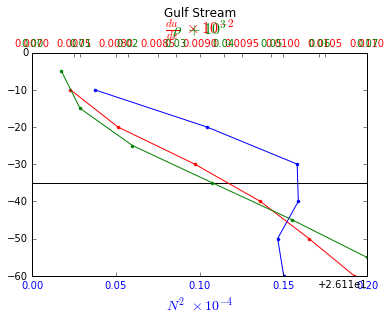

MLD is: 443.377685547
[ -6.60739478e-07   4.37184737e-08   2.41212683e-07   2.11895371e-07
   2.20558451e-07   2.49465933e-07   2.85583905e-07   2.95141465e-07
   3.18701991e-07   3.38103486e-07   3.51715826e-07   3.65964901e-07
   3.73511770e-07   3.86452521e-07   3.99395447e-07   4.13488622e-07
   4.33908095e-07   4.44559024e-07   4.72522262e-07   4.96090978e-07
   5.22291553e-07   5.62362693e-07   5.96554032e-07   6.49541870e-07
   7.37082604e-07   8.34946234e-07   9.53476585e-07   1.10942147e-06
   1.30053053e-06   1.53911412e-06   1.91184848e-06   2.36621584e-06
   3.02672254e-06   3.88420835e-06   4.87146652e-06   5.94713703e-06
   7.13496640e-06   8.30327072e-06   8.91161517e-06              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
            

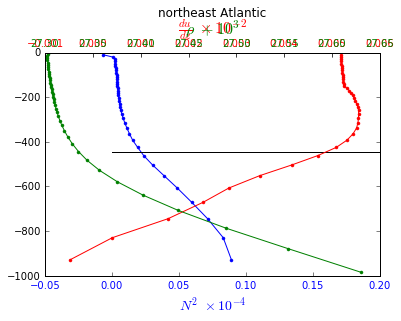

MLD is: 65.0
[  4.80865776e-06   3.70167119e-06   4.74107075e-06   5.73985259e-06
   5.90955108e-06   5.46750237e-06   5.44027035e-06   7.21702004e-06
   1.64130852e-05   3.61195100e-05   6.85824950e-05   9.44447546e-05]
[  8.01402292e-05   8.02680896e-05   7.90344709e-05   7.55070578e-05
   7.04439721e-05   6.62831857e-05   6.24961908e-05   5.97788883e-05
   5.52903877e-05   4.43715113e-05   2.99066015e-05   1.46706894e-05]


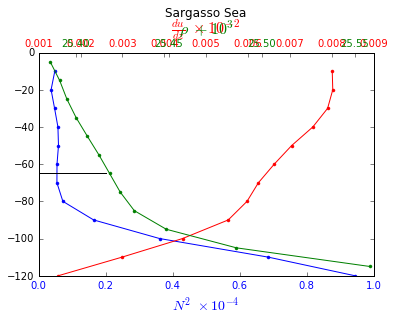

MLD is: 35.0
[  3.49638476e-06   5.45502640e-06   1.05828230e-05   2.70427750e-05
   6.10615635e-05   9.04384456e-05]
[  2.32828872e-05   2.33002731e-05   2.41079725e-05   2.64214933e-05
   2.81005456e-05   3.19733771e-05]


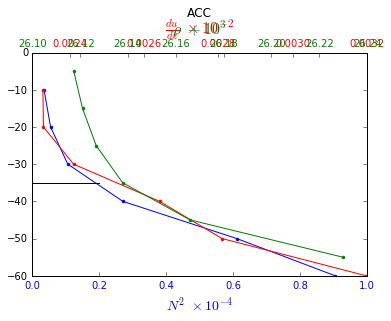

In [125]:
for r in range(7):
    plt_func(N2_winmeta, MLD_winmeta, rho_winmeta, dudz_winmeta, kz_winmeta, lats[r], lons[r], regions[r])

## SUMMER

MLD is: 15.0
[  3.20663650e-05   1.36447280e-04]
[ 0.00033636  0.00037329]


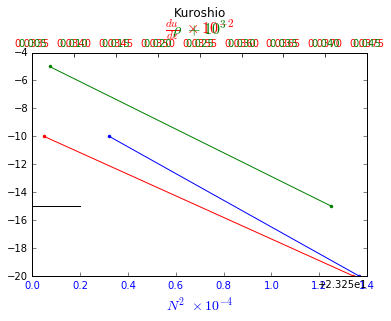

MLD is: 15.0
[  3.95214551e-05   1.82448010e-04]
[  1.16399073e-04   9.70665289e-05]


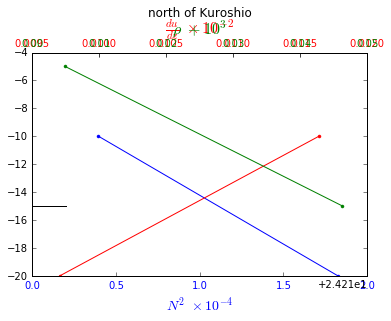

MLD is: 25.0
[  9.47626168e-06   2.57319634e-05   8.34182676e-05   1.78233984e-04]
[ 0.00062937  0.0006261   0.00063479  0.00063629]


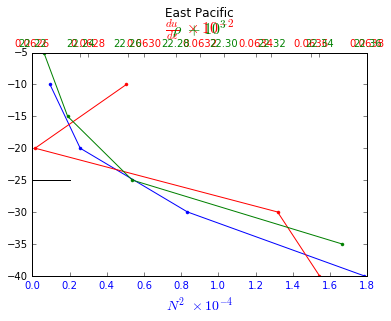

MLD is: 15.0
[  4.41512936e-05   2.54279121e-04]
[ -1.90321621e-04  -3.27467009e-05]


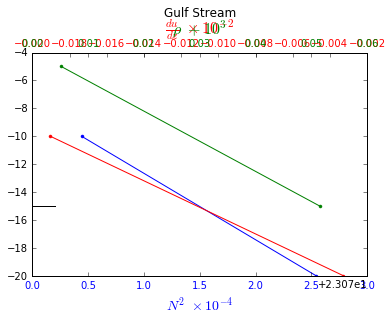

MLD is: 25.0
[  8.56031986e-06   2.06766144e-05   5.53306191e-05   1.08587965e-04]
[  9.92139597e-05   9.76660047e-05   9.52934704e-05   8.44734672e-05]


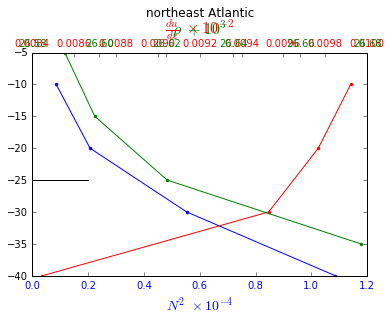

MLD is: 35.0
[  7.52888243e-06   7.44538281e-06   1.17614894e-05   2.77402611e-05
   8.15342324e-05   1.75960419e-04]
[  4.31955032e-05   4.36269044e-05   4.09871403e-05   3.38446685e-05
   3.46479813e-05   4.82904397e-05]


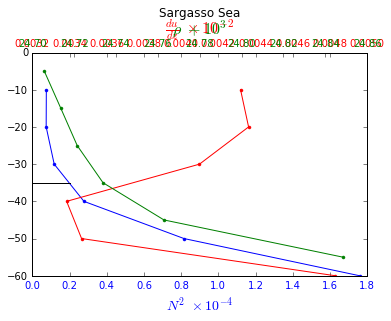

MLD is: 197.660263062
[  4.17177692e-08   2.41513100e-07   3.15782877e-07   3.69995197e-07
   4.66259782e-07   4.93692168e-07   5.25637155e-07   5.44398681e-07
   5.72256488e-07   6.43959591e-07   7.43464104e-07   9.04468750e-07
   1.05923930e-06   1.43832246e-06   2.03076081e-06   2.81502979e-06
   4.03277073e-06   5.10397226e-06   5.38695404e-06   5.36404122e-06
   5.37633149e-06   5.35748213e-06   5.34877606e-06   5.43294396e-06
   5.64449064e-06   5.86709653e-06   6.23209392e-06   6.65078821e-06
   7.03965623e-06   7.65377604e-06   8.12258877e-06   8.59233570e-06
   8.90557300e-06   9.27299014e-06   9.49212577e-06   9.47869248e-06
   9.25210646e-06   9.14748912e-06]
[  2.46975396e-05   2.47614424e-05   2.48030547e-05   2.49041129e-05
   2.50365217e-05   2.51348057e-05   2.52320609e-05   2.52400366e-05
   2.51945421e-05   2.51937920e-05   2.53494959e-05   2.56990219e-05
   2.61470278e-05   2.67052551e-05   2.76225026e-05   2.91821745e-05
   3.02744012e-05   3.12126050e-05   3.229025

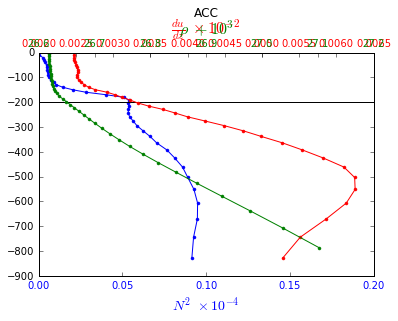

In [126]:
for r in range(7):
    plt_func(N2_summeta, MLD_summeta, rho_summeta, dudz_summeta, kz_summeta, lats[r], lons[r], regions[r])

# Save global picture of MLD

In [123]:
np.savez(os.path.join(basedir, 'MLD_density_criteria'),
        kz_win=kz_winmeta, kz_sum=kz_summeta,
        MLD_win=MLD_winmeta, MLD_sum=MLD_summeta
        )

In [20]:
io.savemat(os.path.join(basedir, 'Density_Kuroshio'),
        {'winter': rhoKuro_win, 'summer': rhoKuro_sum}
        )

In [22]:
io.savemat(os.path.join(basedir, 'Density_GulfStream'),
        {'winter': rhoGS_win, 'summer': rhoGS_sum}
        )

# Plot MLD seasonality

In [6]:
MLDnpz = np.load(os.path.join(basedir, 'MLD_density_criteria.npz'))
print MLDnpz.files
MLD_win = MLDnpz['MLD_win']
MLD_sum = MLDnpz['MLD_sum']

['kz_sum', 'kz_win', 'MLD_win', 'MLD_sum']


In [7]:
from mpl_toolkits.basemap import Basemap
m = Basemap(projection='robin', lon_0=180)

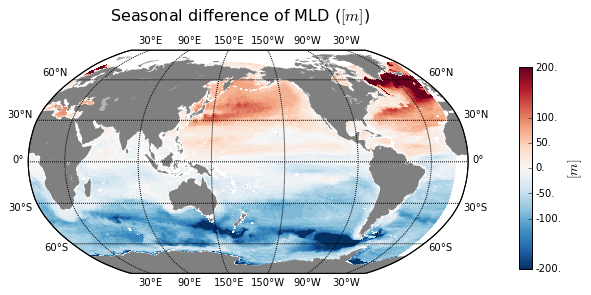

In [9]:
fig = plt.figure(figsize=(9,4))

axi1 = fig.add_subplot(111)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x, y = m(np.ma.masked_invalid(np.roll(lon, -110, axis=1)[:210, :350]), 
         np.ma.masked_invalid(np.roll(lat, -110, axis=1)[:210, :350]))
# x, y = m(np.ma.masked_invalid(lat2),
#         np.ma.masked_invalid(lon2))
pc = m.pcolor(x, y, 
                  np.ma.masked_invalid(np.roll(MLD_win - MLD_sum, -110, axis=1)[:210, :350]), cmap='RdBu_r',
             vmin=-2e2, vmax=2e2)
# pc.set_clim([1, 2.5])
# axi1.set_title(r'winter', fontsize=16, y=1.06)
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);


cbar_axim = fig.add_axes([0.93, 0.14, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_axim, ticks=[-2e2, -1e2, -5e1, 0., 5e1, 1e2, 2e2])
cbar.set_ticklabels(['-200.','-100.','-50.','0.', 
                    '50.','100.','200.'])
cbar.set_label(r'$[m]$', fontsize=14)

plt.suptitle(r'Seasonal difference of MLD ($[m]$)', fontsize=16, y=1.05)
plt.savefig('POP_diffMLD_seasonal.pdf', bbox_inches='tight')

# Find the deepest MLD among the 41 years

In [39]:
winter = np.array(['Jan', 'Feb', 'Mar'])

In [ ]:
m = 1
for month in winter:
    
    for year in range(32):    
        fname = os.path.join(basedir, '3D_Monthly/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.%04d-%02d.nc' % (year+50, m))
        print fname
        if os.path.exists(fname):
            data = xray.open_dataset(fname, decode_times=False)
            lat = data.TLAT.values
            lon = data.TLONG.values
            potT = data.TEMP[0].values
            pracS = data.SALT[0].values
            SSH = 1e-2 * data.SSH[0].values
            z = 1e-2 * data.z_t.values
            P = gsw.p_from_z(SSH-z[:, np.newaxis, np.newaxis], lat[np.newaxis])
            absS = gsw.SA_from_SP(pracS, P, lon[np.newaxis], lat[np.newaxis])
            consT = gsw.CT_from_pt(absS, potT)
            rho = gsw.rho(absS, consT, 0.)

            if year == 0:
                Nz, Ny, Nx = rho.shape
                Nyagg = Ny/10; Nxagg = Nx/10
                rho1 = np.empty((Nz, Nyagg, Nxagg))
                rho1[:] = np.nan
                MLD_maxtempo = rho1[0].copy()

            for k in range(Nz):
                rho1[k] = aggregate(rho[k], factor=10)
            for j in range(Nyagg):
                for i in range(Nxagg):
                    for k in range(Nz):
                        if rho1[k, j, i] - rho1[0, j, i] > .03:
                            MLD_maxtempo[j,i] = z[k]
                            break
        else:
            print 'File does not exist!'

        if year == 0:
            MLD_max = MLD_maxtempo
        for j in range(Nyagg):
            for i in range(Nxagg):
                if MLD_max[j,i] < MLD_maxtempo[j,i]:
                    MLD_max[j,i] = MLD_maxtempo[j,i]
    
    
    savename = os.path.join(basedir, 'MLDmax_%3s' % month)
    print savename
    np.savez(savename, MLD=MLD_max)
    
    m += 1

/data/scratch/takaya/POP_data/3D_Monthly/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-01.nc
/data/scratch/takaya/POP_data/3D_Monthly/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0051-01.nc
/data/scratch/takaya/POP_data/3D_Monthly/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0052-01.nc
/data/scratch/takaya/POP_data/3D_Monthly/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0053-01.nc
/data/scratch/takaya/POP_data/3D_Monthly/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0054-01.nc
/data/scratch/takaya/POP_data/3D_Monthly/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0055-01.nc
/data/scratch/takaya/POP_data/3D_Monthly/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0056-01.nc
/data/scratch/takaya/POP_data/3D_Monthly/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0057-01.nc
/data/scratch/takaya/POP_data/3D_Monthly/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0058-01.nc
/data/scratch/takaya/POP_data/3D_Monthly/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0059-01.nc
/data/scratch/takaya/POP_data/3D_Monthly/hybrid_v5_rel04_BC5

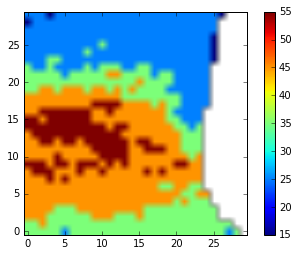

In [37]:
plt.imshow(MLD_max, origin='bottom')
plt.colorbar()

In [42]:
summer = np.array(['Jul', 'Aug', 'Sep'])

In [ ]:
m = 7
for month in summer:
    
    for year in range(32):    
        fname = os.path.join(basedir, '3D_Monthly/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.%04d-%02d.nc' % (year+50, m))
        print fname
        if os.path.exists(fname):
            data = xray.open_dataset(fname, decode_times=False)
            lat = data.TLAT.values
            lon = data.TLONG.values
            potT = data.TEMP[0].values
            pracS = data.SALT[0].values
            SSH = 1e-2 * data.SSH[0].values
            z = 1e-2 * data.z_t.values
            P = gsw.p_from_z(SSH-z[:, np.newaxis, np.newaxis], lat[np.newaxis])
            absS = gsw.SA_from_SP(pracS, P, lon[np.newaxis], lat[np.newaxis])
            consT = gsw.CT_from_pt(absS, potT)
            rho = gsw.rho(absS, consT, 0.)

            if year == 0:
                Nz, Ny, Nx = rho.shape
                Nyagg = Ny/10; Nxagg = Nx/10
                rho1 = np.empty((Nz, Nyagg, Nxagg))
                rho1[:] = np.nan
                MLD_maxtempo = rho1[0].copy()

            for k in range(Nz):
                rho1[k] = aggregate(rho[k], factor=10)
            for j in range(Nyagg):
                for i in range(Nxagg):
                    for k in range(Nz):
                        if rho1[k, j, i] - rho1[0, j, i] > .03:
                            MLD_maxtempo[j,i] = z[k]
                            break
        else:
            print 'File does not exist!'

        if year == 0:
            MLD_max = MLD_maxtempo
        for j in range(Nyagg):
            for i in range(Nxagg):
                if MLD_max[j,i] < MLD_maxtempo[j,i]:
                    MLD_max[j,i] = MLD_maxtempo[j,i]
    
    
    savename = os.path.join(basedir, 'MLDmax_%3s' % month)
    print savename
    np.savez(savename, MLD=MLD_max)
    
    m += 1